# Exploratory Analysis of data

This notebook examins the time patterns, seasonal effects, correlations among pollutants, and relationships between meterological and chemical variables in the Air Quality dataset from UCI.



## Setup

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
path_to_data = "../../dataset/raw/AirQualityUCI.csv"

df = pd.read_csv(
    path_to_data,
    sep=';',          
)

df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


# Data quality analysis

## Missing values
Firstly, observe that the dataset contains sentinel values `-200` as a placeholder for missing values (See row 9 above).

This will need to be treated as missing data appropriately using `NaN` during data preprocessing, otherwise statistical analysis (e.g finding mean) will be skewed and machine learning models would be factoring in incorrect data during their training process.



In [19]:
sentinel_mask = (df == -200.0)
sentinel_counts = sentinel_mask.sum()

print("Number of Sentinel values per variable")
print(sentinel_counts[sentinel_counts > 0].sort_values(ascending=False))

Number of Sentinel values per variable
NMHC(GT)         8443
NO2(GT)          1642
NOx(GT)          1639
PT08.S1(CO)       366
PT08.S2(NMHC)     366
PT08.S3(NOx)      366
PT08.S4(NO2)      366
PT08.S5(O3)       366
dtype: int64


* We can see that `NMHC(GT)` is missing 8443 values (~90% of total data), thus it is unusable as a target variable for our models and will need to be removed during processing.
  
*  Relative pollutants such as `CO(GT)`, `NO2(GT)` `NOx(GT)` are missing a number of values between [1600, 1700] (~17% of total data). 
  
*  Finally, sensors and meterology `PT08.S` series, `T`, `RH`, `AH` show a gap of exactly 366 sentinels (~4% of total data).
  
The fact that 10 columns share the exact same count of sentinel values (366) strongly suggests that these gaps are not random, rather it may be caused by synchronized system downtime or data logging failure. This is confirmed by observing entries in the dataset where many variables are missing values, shown below.

In [20]:
df.iloc[6700:6710]

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
6700,14/12/2004,22.00.00,"2,5",-200.0,-200.0,"-200,0",-200.0,341.0,-200.0,112.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6701,14/12/2004,23.00.00,"2,1",-200.0,-200.0,"-200,0",-200.0,365.0,-200.0,108.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6702,15/12/2004,00.00.00,"2,9",-200.0,-200.0,"-200,0",-200.0,510.0,-200.0,115.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6703,15/12/2004,01.00.00,"2,3",-200.0,-200.0,"-200,0",-200.0,352.0,-200.0,96.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6704,15/12/2004,02.00.00,"1,7",-200.0,-200.0,"-200,0",-200.0,299.0,-200.0,87.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6705,15/12/2004,03.00.00,"0,9",-200.0,-200.0,"-200,0",-200.0,-200.0,-200.0,-200.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6706,15/12/2004,04.00.00,"0,7",-200.0,-200.0,"-200,0",-200.0,103.0,-200.0,61.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6707,15/12/2004,05.00.00,"0,8",-200.0,-200.0,"-200,0",-200.0,133.0,-200.0,61.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6708,15/12/2004,06.00.00,1,-200.0,-200.0,"-200,0",-200.0,244.0,-200.0,82.0,-200.0,-200.0,-200,-200,-200,NaN,NaN
6709,15/12/2004,07.00.00,"1,2",-200.0,-200.0,"-200,0",-200.0,222.0,-200.0,83.0,-200.0,-200.0,-200,-200,-200,NaN,NaN


## Trailing rows and columns

The dataset contains trailing, empty rows and columns that need to be stripped out in pre-processing. 
* Empty rows begin at `9538` and end at `9470`, meaning we need to strip the last 112 rows from the dataset. 
* Columns `15` and `16` are also empty and need to be stripped.

In [21]:
df.tail()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
9466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9467,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Comma Decimal separator
The raw data uses commas to mark decimal places instead of `.`. If not addressed, this makes the columns non-numeric, breaking math operations.

# Analysis of Relationships and Correlations

We will now analyse trends and relationships in the dataset using visualizations. Note that this uses a basic processed dataset with a pipeline that addresses the above issues.

In [45]:
df_processed = pd.read_csv('../../dataset/processed/AirQualityUCI_processed.csv')
df_processed.head()

,DateTime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


## Time patterns
To analyse the time patterns of the dataset, we examine the **Diurnal Pattern** (Average hourly cycle) over a 24 hour period and also the **Seasonal Pattern** for long-term monthly trends. We will observe the behaviour of pollutant concentration, sensor information, and meteorology values and extract meaningful patterns

### Diurnal Pattern (Hourly analysis)

<Figure size 1000x500 with 0 Axes>

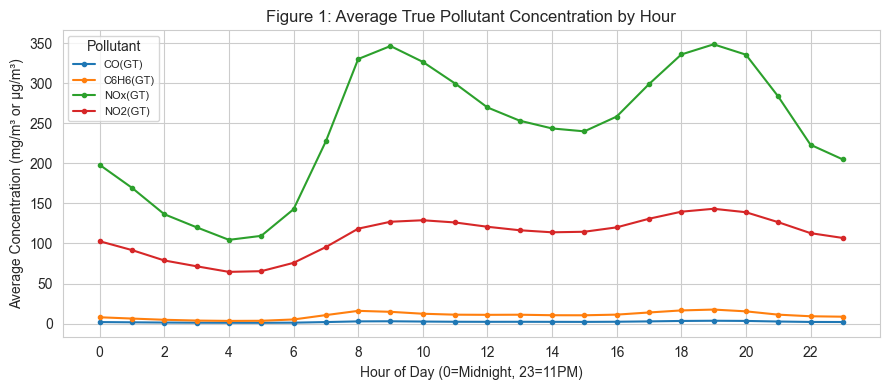

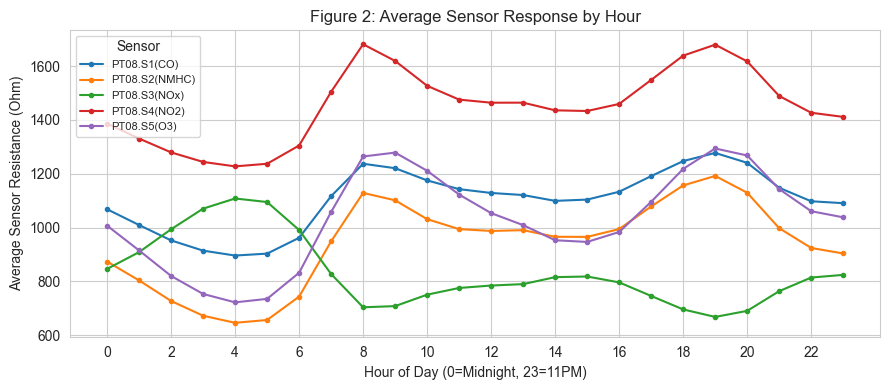

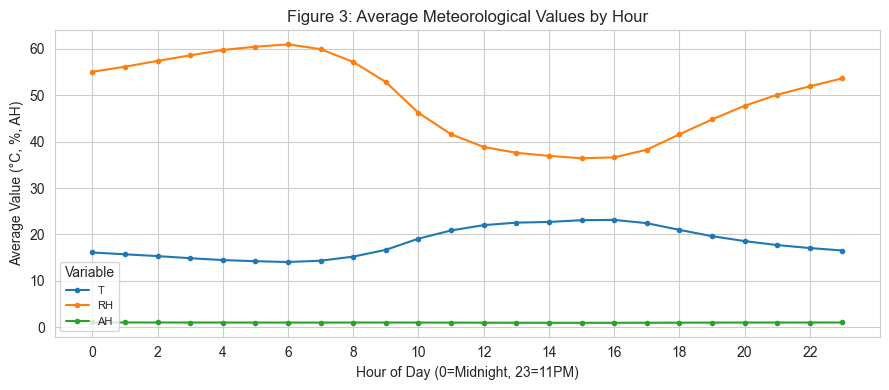

In [46]:
# Set 'DateTime' as the index and ensure it's a datetime object
df_processed.set_index('DateTime', inplace=True)
df_processed.index = pd.to_datetime(df_processed.index)

# Create time-based features for analysis
df_processed['Hour'] = df_processed.index.hour
df_processed['Month'] = df_processed.index.month

pollutant_cols = ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
meteo_cols = ['T', 'RH', 'AH']
sensor_cols = [col for col in df_processed.columns if 'PT08.S' in col]
sns.set_style("whitegrid")

# Diurnal Pattern (Hourly) Plot
plt.figure(figsize=(10, 5))

# --- Plot 1: Pollutants (GT) Diurnal Cycle ---
plt.figure(figsize=(9, 4)) # Reduced figure size
df_processed.groupby('Hour')[pollutant_cols].mean().plot(ax=plt.gca(), marker='.', linestyle='-')
plt.title('Figure 1: Average True Pollutant Concentration by Hour', fontsize=12) # Smaller title
plt.ylabel('Average Concentration (mg/m³ or µg/m³)', fontsize=10) # More specific Y-label
plt.xlabel('Hour of Day (0=Midnight, 23=11PM)', fontsize=10) # Smaller X-label
plt.xticks(range(0, 24, 2))
plt.legend(loc='upper left', title='Pollutant', fontsize=8) # Smaller legend
plt.tight_layout()
plt.show()

# --- Plot 2: Sensor Responses Diurnal Cycle ---
plt.figure(figsize=(9, 4)) 
df_processed.groupby('Hour')[sensor_cols].mean().plot(ax=plt.gca(), marker='.', linestyle='-')
plt.title('Figure 2: Average Sensor Response by Hour', fontsize=12) 
plt.ylabel('Average Sensor Resistance (Ohm)', fontsize=10) 
plt.xlabel('Hour of Day (0=Midnight, 23=11PM)', fontsize=10) 
plt.xticks(range(0, 24, 2))
plt.legend(loc='upper left', title='Sensor', fontsize=8) 
plt.tight_layout()
plt.show()

# --- Plot 3: Meteorology Diurnal Cycle ---
plt.figure(figsize=(9, 4)) 
df_processed.groupby('Hour')[meteo_cols].mean().plot(ax=plt.gca(), marker='.', linestyle='-')
plt.title('Figure 3: Average Meteorological Values by Hour', fontsize=12) 
plt.ylabel('Average Value (°C, %, AH)', fontsize=10) 
plt.xlabel('Hour of Day (0=Midnight, 23=11PM)', fontsize=10) 
plt.xticks(range(0, 24, 2))
plt.legend(loc='lower left', title='Variable', fontsize=8) 
plt.tight_layout()
plt.show()

**Figure 1:**
* Pollutants exhibit a general pattern of a bimodal cycle, peaking during the morning (7-10am) and evening (5-8pm), potentiually indicating that peak-hour traffic is a major contributor to pollutant conecentration. Thus we identify the `Hour` feature as a strong feature for prediction models.

**Figure 2:**
* The PT08.S sensors also show a similar bimodal pattern, generally peaking during the morning and evening.

**Figure 3:**
* From the diurnal analysis alone, it is difficult to see a relationship between hourly meteorolgy values and the other metrics above. Perhaps seasonal patterns may reveal something more consistent.

## Seasonal effects


/var/folders/_x/vk9nlbc978g9l5wsy5yyt5br0000gn/T/ipykernel_4000/1476771494.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_processed[plot_cols_seasonal].resample('M').mean().plot(ax=plt.gca(), marker='o', linestyle='-')


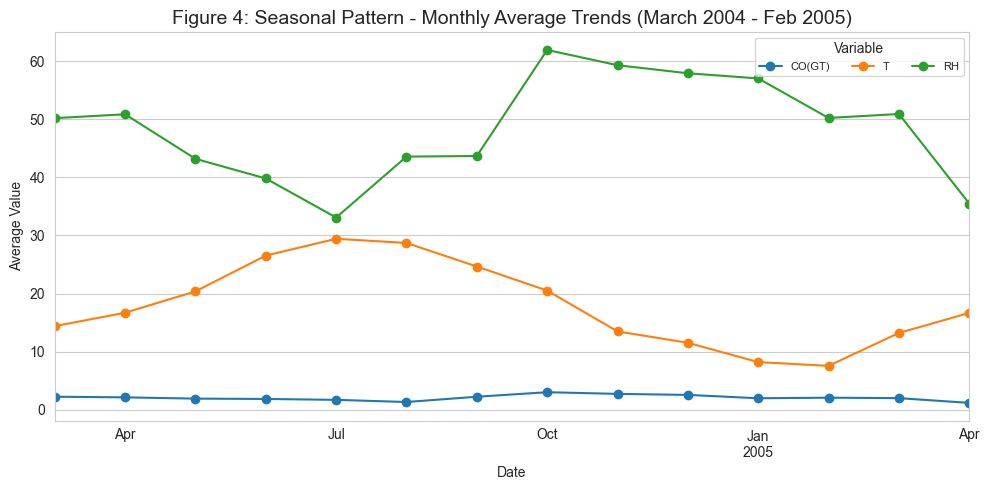

In [51]:
plot_cols_seasonal = ['CO(GT)','T', 'RH']
sns.set_style("whitegrid")


plt.figure(figsize=(10, 5))
# Resample to the Monthly mean ('M') for a cleaner view of the trend
df_processed[plot_cols_seasonal].resample('M').mean().plot(ax=plt.gca(), marker='o', linestyle='-')

plt.title('Figure 4: Seasonal Pattern - Monthly Average Trends (March 2004 - Feb 2005)', fontsize=14)
plt.ylabel('Average Value', fontsize=10)
plt.xlabel('Date', fontsize=10)
plt.legend(loc='upper right', ncol=3, title='Variable', fontsize=8)
plt.grid(axis='x') # Add grid lines for date readability
plt.tight_layout()
plt.show()